In [1]:
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve

# Accuracy, precision and recall from scratch

In [28]:
y_test = [1, 1, 1, 0, 0, 0, 1, 0]
y_proba = [0.9, 0.7, 0.1, 0.2, 0.4, 0.6, 0.7, 0.1]

y_pred = [int(round(x, 0)) for x in y_proba]

y_comb = pd.DataFrame()
y_comb['true'] = y_test
y_comb['pred'] = y_pred

y_comb.loc[ (y_comb['true'] == y_comb['pred']) & (y_comb['pred']==1), 'confu' ] = 'TP'
y_comb.loc[ (y_comb['true'] == y_comb['pred']) & (y_comb['pred']==0), 'confu' ] = 'TN'
y_comb.loc[ (y_comb['true'] != y_comb['pred']) & (y_comb['pred']==1), 'confu' ] = 'FP'
y_comb.loc[ (y_comb['true'] != y_comb['pred']) & (y_comb['pred']==0), 'confu' ] = 'FN'

tp = len(y_comb[y_comb['confu']=='TP'])
tn = len(y_comb[y_comb['confu']=='TN'])
fp = len(y_comb[y_comb['confu']=='FP'])
fn = len(y_comb[y_comb['confu']=='FN'])

confusion_matrix = pd.DataFrame([[tp, fp], [fn, tn]])
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)

print(confusion_matrix, accuracy, precision)

   0  1
0  3  1
1  1  3 0.75 0.75


# Evaluate your model

## 1. Define Business Goal

Predict survival outcome for titanic

## 2. Get Data

In [29]:
df = pd.read_csv('data/train.csv')

## 3. Train-Test Split

In [30]:
X = df.drop(['Survived'], axis=1)
y = df['Survived']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

## 4. Explore Data

In [195]:
X_train.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
733,734,2,"Berriman, Mr. William John",male,23.0,0,0,28425,13.00,NaN,S
857,858,1,"Daly, Mr. Peter Denis",male,51.0,0,0,113055,26.55,E17,S
81,82,3,"Sheerlinck, Mr. Jan Baptist",male,29.0,0,0,345779,9.50,NaN,S
319,320,1,"Spedden, Mrs. Frederic Oakley (Margaretta Corn...",female,40.0,1,1,16966,134.50,E34,C
720,721,2,"Harper, Miss. Annie Jessie ""Nina""",female,6.0,0,1,248727,33.00,NaN,S


In [196]:
y_train.head()

733    0
857    1
81     1
319    1
720    1
Name: Survived, dtype: int64

In [197]:
X_train.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            135
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          555
Embarked         2
dtype: int64

## 5. Feature Engineering

In [32]:
def process(df):
    
    df.drop(['Cabin', 'Ticket', 'Fare', 'Name', 'PassengerId'], inplace=True, axis=1)
    
    df = df.fillna({'Age':df['Age'].mean(), 'Embarked':'S'})
    
    df['Age'] = (df['Age'] - df['Age'].mean()) / df['Age'].std()

    df['Sex'].replace({'male':0, 'female':1}, inplace=True)
    
    df['Embarked'].replace({'C':1, 'Q':0, 'S':0}, inplace=True)

    return df

In [33]:
X_train = process(X_train)

/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/pandas/core/frame.py:4908: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## 6. Train Model

In [34]:
m = LogisticRegression()

In [35]:
m.fit(X_train, y_train)

LogisticRegression()

In [36]:
m.coef_, m.intercept_

(array([[-1.08815535,  2.54590915, -0.47454174, -0.28869486, -0.05789759,
          0.39247826]]),
 array([1.00738853]))

In [61]:
m2 = LogisticRegression(class_weight='balanced')

In [62]:
m2.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [63]:
m.coef_, m.intercept_

(array([[-1.08815535,  2.54590915, -0.47454174, -0.28869486, -0.05789759,
          0.39247826]]),
 array([1.00738853]))

## 7. Optimize Hyperparameters / Cross-Validation

## 8. Calculate Test Score

In [221]:
[(a, b) for (a, b) in zip(m.coef_[0], X_train.columns)]

[(-1.0881553499484948, 'Pclass'),
 (2.5459091532817015, 'Sex'),
 (-0.4745417406571986, 'Age'),
 (-0.28869485571890496, 'SibSp'),
 (-0.057897589890610376, 'Parch'),
 (0.3924782574818066, 'Embarked')]

In [44]:
X_test = process(X_test)

/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/pandas/core/frame.py:4908: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [60]:
"""
Creates a table of probability of 1 (survived), 0 (drowned) on X_test dataset and true outcome
"""

estimates_y_test = m.predict_proba(X_test)

estimates_y_test = pd.DataFrame(data=estimates_y_test, columns=['0','1'])

true_y_test = y_test.reset_index().drop('index', axis=1)

estimates_y_test.join(true_y_test)

,0,1,Survived
0,0.657792,0.342208,0
1,0.047625,0.952375,1
2,0.494782,0.505218,0
3,0.810338,0.189662,1
4,0.762950,0.237050,0
...,...,...,...
174,0.905259,0.094741,0
175,0.905259,0.094741,0
176,0.136409,0.863591,1
177,0.948857,0.051143,0


In [64]:
m.score(X_train, y_train), m2.score(X_train, y_train)

(0.8047752808988764, 0.7837078651685393)

In [66]:
from sklearn.utils.class_weight import compute_class_weight

In [98]:
"""
Validate understanding of class_weight 
"""

sklearn_calculation_class_weight = compute_class_weight(class_weight='balanced', classes=[0,1], y=y_train)
sklearn_calculation_class_weight = sklearn_calculation_class_weight / sum(sklearn_calculation_class_weight)

manual_calculation_class_weight = y_train.value_counts(ascending=True)
manual_calculation_class_weight = list(manual_calculation_class_weight / sum(manual_calculation_class_weight))

sklearn_calculation_class_weight == manual_calculation_class_weight

array([ True,  True])

In [224]:
X_test = process(X_test)

/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/pandas/core/frame.py:4908: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [225]:
accuracy_test = m.score(X_test, y_test)
print(accuracy_test)

0.8156424581005587


In [226]:
y_pred = m.predict(X_test)

In [227]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84        99
           1       0.84      0.72      0.78        80

    accuracy                           0.82       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.82      0.82      0.81       179



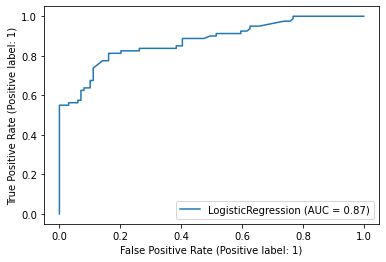

In [228]:
plot_roc_curve(estimator=m, X=X_test, y=y_test)

## 9. Deploy & Monitor

# Decision Boundary

## Problem 2.3.2

In [1]:
from sklearn.datasets import make_moons
from sklearn.linear_model import LogisticRegression

In [ ]:
X, y = make_moons(n_samples=200, noise=0.3)

In [11]:
m = LogisticRegression(C=1e5)
m.fit(X, y)

print(m.coef_)
print(m.score(X, y))

[[ 1.06262823 -4.72993915]]
0.855


## 2.3.3 Example using Statsmodels

In [15]:
import statsmodels.discrete.discrete_model as sm
import pandas as pd
import numpy as np

In [26]:
logit = sm.Logit(y, X)

f = logit.fit()
print(f.params)
print(f.summary())
predictions = pd.Series(f.predict(X) )
def func(x):     
    if x < 0.5:         
        return 0     
    else:         
        return 1 
predictions = predictions.apply(func) 
helper = y + predictions
accuracy = []
for element in helper:
    if element == 1:
        accuracy.append(0)
    else:
        accuracy.append(1)
print(sum(accuracy)/len(accuracy))

Optimization terminated successfully.
         Current function value: 0.305982
         Iterations 8
[ 1.26170196 -4.2147937 ]
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  200
Model:                          Logit   Df Residuals:                      198
Method:                           MLE   Df Model:                            1
Date:                Thu, 07 Oct 2021   Pseudo R-squ.:                  0.5586
Time:                        12:16:07   Log-Likelihood:                -61.196
converged:                       True   LL-Null:                       -138.63
Covariance Type:            nonrobust   LLR p-value:                 1.498e-35
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.2617      0.234      5.396      0.000       0.803       1.720
x2 

## Recap Questions

In [104]:
w1 = 0.5
w2 = 2.0
b = -1.0
x1 = 10.0
x2 = -0.1


y = 1 / (1 + np.exp(-(b + w1*x1 + w2*x2)))
print(y)

0.9781187290638694


In [136]:
[1 for i in x]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

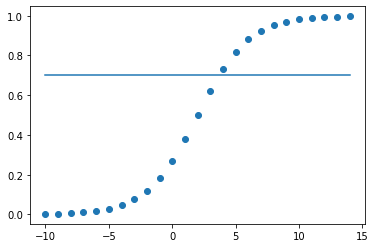

In [144]:
x = pd.Series([x for x in range(-10,15)])

w1 = 0.5
b = -1.0

def sigmoid(x:float) -> float:
    
    w1 = 0.5
    b = -1.0
    
    return 1 / (1 + np.exp(-(b + w1*x)))

y = x.apply(sigmoid)

y_decision_boundary = [0.7 for i in x]

plt.scatter(x=x, y=y)
plt.plot(x, y_decision_boundary)